In [9]:
from cmath import nan
from ftplib import error_perm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random, shuffle
from numpy.linalg import eig
import time, datetime
from sklearn import linear_model 


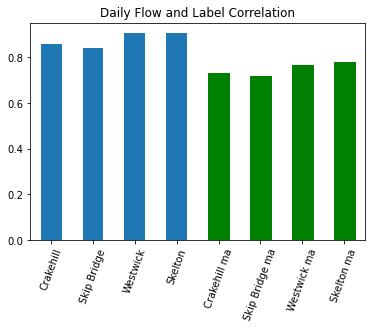

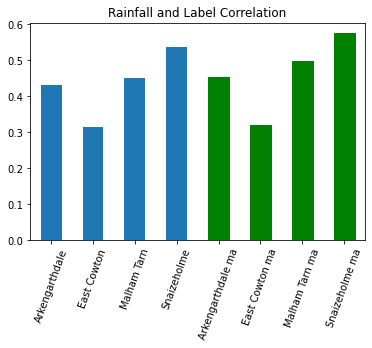

[0.    0.    0.    0.    2.06  1.002 1.954 3.748]


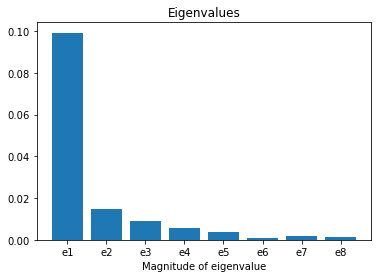

In [19]:
# Import dataset
df = pd.read_excel('data.xlsx', header = 0, skiprows=1, usecols="A:I", index_col=0, parse_dates=True)
#     df_dates = pd.read_excel('data.xlsx', header = 0, skiprows=1, usecols="A")

df.columns = ['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton', 'Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']
df[['Skip Bridge','Skelton','East Cowton']] = df[['Skip Bridge','Skelton','East Cowton']].apply(pd.to_numeric, errors='coerce')

# Daily Flow outliers : upper and lower bound checked
df[['Crakehill','Skip Bridge','Westwick', 'Skelton']] = df[['Crakehill','Skip Bridge','Westwick', 'Skelton']].mask(df.sub(df.mean()).div(df.std()).abs().lt(-3))
df[['Crakehill','Skip Bridge','Westwick', 'Skelton']] = df[['Crakehill','Skip Bridge','Westwick', 'Skelton']].mask(df.sub(df.mean()).div(df.std()).abs().gt(3))

# Daily Rainfall outliers : only upper bound checked
df[['Arkengarthdale','East Cowton','Malham Tarn', 'Snaizeholme']] = df[['Arkengarthdale','East Cowton','Malham Tarn', 'Snaizeholme']].mask(df.sub(df.mean()).div(df.std()).abs().gt(3))

# interpolate all NaN types
df[df < 0] = nan
df = df.interpolate()

# Add labels
labels = df['Skelton']
df = df.shift(1)
df['labels'] = labels
df = df.iloc[1:]


# Moving Averages Plots and correlation comparison
width = 3
lag1 = df.shift(1)
lag3 = df[['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton', 
        'Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']].shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1], axis=1)
dataframe.columns = ['Crakehill ma', 'Skip Bridge ma', 'Westwick ma', 'Skelton ma', 
                     'Arkengarthdale ma', 'East Cowton ma', 'Malham Tarn ma', 'Snaizeholme ma',
                     'Crakehill', 'Skip Bridge', 'Westwick', 'Skelton', 
                     'Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme', 'labels']

dataframe = dataframe.iloc[4:]

flow_corr = dataframe[['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton',
                      'Crakehill ma', 'Skip Bridge ma', 'Westwick ma', 'Skelton ma', 'labels']].corr()['labels'][:-1]

bar_flow = flow_corr.plot.bar(x="", y="Correlation to Labels", rot=70)
for i in range(4):
    bar_flow.get_children()[len(flow_corr)-i-1].set_color('g') 
plt.title("Daily Flow and Label Correlation")
plt.show()
#     print(flow_corr)
#     print()

rain_corr = dataframe[['Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme',
                      'Arkengarthdale ma', 'East Cowton ma', 'Malham Tarn ma', 'Snaizeholme ma', 'labels']].corr()['labels'][:-1]

bar_rain = rain_corr.plot.bar(x="", y="Correlation to Labels", rot=70)
for i in range(4):
    bar_rain.get_children()[len(rain_corr)-i-1].set_color('g') 
plt.title("Rainfall and Label Correlation")
plt.show()
#     print(rain_corr)

# Drop daily flow moving average columns, and total rainfall original values 

df = dataframe.drop(labels=['Crakehill ma', 'Skip Bridge ma', 'Westwick ma', 'Skelton ma',
                           'Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme'], axis=1)

#     print(df)


#     plt.figure(figsize=(10,6))
#     plt.plot(dataframe[['Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']])
#     plt.xlabel("Date")
#     plt.ylabel('Total daily rainfall')
#     plt.gcf().autofmt_xdate()
#     plt.show()

#     plt.figure(figsize=(10,6))
#     plt.plot(dataframe[['Arkengarthdale ma', 'East Cowton ma', 'Malham Tarn ma', 'Snaizeholme ma']])
#     plt.xlabel("Date")
#     plt.ylabel('Total daily rainfall')
#     plt.gcf().autofmt_xdate()
#     plt.show()

#     dataframe['Arkengarthdale'].plot(figsize=(10,6), color='blue')
#     dataframe['Arkengarthdale ma'].plot(color='red')
#     plt.show()

x_set = df.iloc[:,:-1].to_numpy()

y_set = df['labels'].to_numpy()

dates = df.index.values 

# shuffle data
shuffler = np.random.permutation(len(x_set))
x_set_shuffled = x_set[shuffler]
y_set_shuffled = y_set[shuffler]
dates_shuffled = dates[shuffler]

x_split = np.split(x_set_shuffled, [int(.8 * len(x_set_shuffled))])
y_split = np.split(y_set_shuffled, [int(.8 * len(y_set_shuffled))])
dates_split = np.split(dates_shuffled, [int(.8 * len(dates_shuffled))])

x_train, y_train = x_split[0], y_split[0]
x_test, y_test = x_split[1], y_split[1]

dates_train, dates_test = dates_split[0], dates_split[1]


# standardisation betweeen two values a,b : a + (x - min(x))(b-a) / max(x) - min(x)
# take min,max in train+val set and standardise all sets using these values
a = 0.1
b = 0.9

x_train_min = np.amin(x_train, axis=0)
print(x_train_min)
x_train_max = np.amax(x_train, axis=0)
y_train_min = np.amin(y_train, axis=0)
y_train_max = np.amax(y_train, axis=0)

x_train_norm = a + (x_train-x_train_min)*(b-a)/(x_train_max-x_train_min)
x_test_norm = a + (x_test-x_train_min)*(b-a)/(x_train_max-x_train_min)

y_train_norm = a + (y_train-y_train_min)*(b-a)/(y_train_max-y_train_min)
y_test_norm = a + (y_test-y_train_min)*(b-a)/(y_train_max-y_train_min)


# Principal Component Analysis

C = x_train_norm - np.mean(x_train_norm.T, axis=1)
covar = np.cov(C.T) # covariance matrix
values, vectors = eig(covar) # eigendecomposition of covariance matrix

plt.bar(["e" + str(i+1) for i in range(len(values))], values)
plt.title("Eigenvalues")
plt.xlabel("Magnitude of eigenvalue")
plt.show()

vector_cut = vectors[:,:5]
x_train_pca = np.dot(x_train_norm, vector_cut)
x_test_pca = np.dot(x_test_norm, vector_cut)

In [20]:
np.random.seed(3)
class MLP:
    def __init__(self, num_inputs, num_hidden, num_outputs, momentum):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.momentum = momentum

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
        
        
        # initiate random weights
        weights = []
        bias = []
        for i in range(len(layers) - 1):
            w = np.random.default_rng(seed=1).uniform(-2/layers[i-1], 2/layers[i-1], size=(layers[i], layers[i+1]))
            b = np.random.default_rng(seed=1).uniform(-2/layers[i-1], 2/layers[i-1], size=(layers[i+1]))

            weights.append(w)
            bias.append(b)

        self.weights = weights
        self.bias = bias

        
        activations = []
        for i in range(len(layers)):
            a = np.zeros(layers[i])
            activations.append(a)   
        self.activations = activations
        
        derivatives = []
        deltas = []
        for i in range(len(layers) - 1):
            d = np.zeros((layers[i], layers[i+1]))
            delta = np.zeros((layers[i+1]))
            derivatives.append(d) 
            deltas.append(delta)
        self.derivatives = derivatives
        self.deltas = deltas

    def forward_propogate(self, inputs):
        activations = inputs
        self.activations[0] = inputs

        for i, w in enumerate(self.weights):
            # calculate net inputs
            net_inputs = np.dot(activations, w) + self.bias[i]

            # pick activation function
            activations = self._sigmoid(net_inputs)
#             activations = self.tanh(net_inputs)
            
            self.activations[i + 1] = activations

        #return output layer activation
        return activations
    
    def back_propogate(self, error, verbose=False):

        for i in reversed(range(len(self.derivatives))):
            activations = self.activations[i+1]
            
            # pick activation function
            delta = error * self._sigmoid_derivative(activations)
#             delta = error * self.dtanh(activations)
            
            delta_reshaped = delta.reshape(delta.shape[0], -1).T # ndarray([0.1, 0.2]) --> ndarray([[0.1, 0.2]])
            current_activations = self.activations[i]
            current_activations_reshaped = current_activations.reshape(current_activations.shape[0], -1) # ndarray([0.1, 0.2]) --> ndarray([[0.1], [0.2]])
            self.derivatives[i] = np.dot(current_activations_reshaped, delta_reshaped)
            self.deltas[i] = delta
            error = np.dot(delta, self.weights[i].T)

            if verbose:
                print('Derivatives for W{}: {}'.format(i, self.derivatives[i]))

        return error

    def grad_descent(self, learning_rate):
        for i in range(len(self.weights)):
            weights = self.weights[i]
            b = self.bias[i]
            delta = self.deltas[i]
            derivatives = self.derivatives[i]
            
            # With Momentum
            if (self.momentum != 0):
                
                old_weights = self.weights[i]
                old_b = self.bias[i]
                
                weights += (derivatives * learning_rate)
                weight_momentum = weights - old_weights
                
                b += (delta * learning_rate)
                b_momentum = b - old_b

                weights += (self.momentum * weight_momentum) +  (derivatives * learning_rate)
                b += (self.momentum * b_momentum) + (delta * learning_rate)
           
            # Without Momentum
            else:

                weights += (derivatives * learning_rate)
                b += (delta * learning_rate)
        

    def train(self, X, Y, D, epochs, learning_rate):
        
        Xs = np.split(X, [int(.8 * len(X))])
        Ys = np.split(Y, [int(.8 * len(Y))])
        Ds = np.split(D, [int(.8 * len(D))])

        x_train, x_valid = Xs[0], Xs[1]
        y_train, y_valid = Ys[0], Ys[1]
        d_train, d_valid = Ds[0], Ds[1]
            
        train_error_list = []
        valid_error_list = []
        count = 0
        for i in range(epochs):
            train_error = 0
            valid_error = 0
            # Train
            
            # Simulated Annealing
#             learning_rate = self.sim_annealing(epochs, i, learning_rate, 0.01)
            
            for x, y in zip(x_train, y_train):
                
                # forward propagation
                output = self.forward_propogate(x)

                # calculate error
                error = y - output

                # back propagation
                self.back_propogate(error)

                # gradient descent
                self.grad_descent(learning_rate)
                
                # mean square error
                train_error += self._mse(y, output)
            
            # Validate
            for x, y in zip(x_valid, y_valid):
                
                # forward propagation
                output = self.forward_propogate(x)
                
                valid_error += self._mse(y, output)
                  
            # report error
            rmse_train = np.sqrt(train_error / len(x_train))
            rmse_valid = np.sqrt(valid_error / len(x_valid))
            
            train_error_list.append(rmse_train)
            valid_error_list.append(rmse_valid)
            
            if (count == 10):
                print('train error: {} , validation error: {} at epoch {}'.format(rmse_train, rmse_valid, i))
                count = 0
            count += 1
            
        plt.plot(train_error_list, label='train error', color='blue')
        plt.plot(valid_error_list, label='validation error', color='orange')
        leg = plt.legend(loc='upper right')
        plt.xticks(range(0,len(train_error_list)+1, 100))
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.show()
             
    
    def sim_annealing(self, r, x, p, q):
        return p + (q - p) * (1 - (1 / (1 + np.exp(10 - (20 * x / r)))))
   

    # mean squared error
    def _mse(self, target, output):  

        output = ((output*(y_train_max - y_train_min) - a)/(b - a)) + y_train_min
        target = ((target*(y_train_max - y_train_min) - a)/(b - a)) + y_train_min
        return np.average((target - output)**2)

    def _sigmoid_derivative(self, x):
        return x * (1.0 - x)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def dtanh(self, x):
        return 1 - x**2
    

In [15]:
class LinearRegression:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        reg = linear_model.LinearRegression()
        reg.fit(x_train, y_train)
        predict = regr.predict(x_test)
        
        plt.scatter(predict, y_test)
        plt.xlabel('Expected')
        plt.ylabel('Predictions')

            
        

            

In [22]:
np.random.seed(3)
if __name__ == "__main__":  
    
    # create an MLP
    mlp = MLP(8, [20, 20, 20], 1, 0.9)
    
    #train MLP
    start = datetime.datetime.now()
    mlp.train(x_train_pca, y_train_norm, dates_train, 500, 0.5)
    end = datetime.datetime.now()
    
    training_time = end - start
    time_s = int(training_time.total_seconds())
    print('Training Time: {}'.format(training_time))
    print('Seconds: {}'.format(time_s))

    # Multivariate Linear Regression
#     linear_reg = LinearRegression(x_train_norm, x_test_norm, y_train_norm, y_test_norm)
    
    # test data
#     output = mlp.forward_propogate(x_test_norm)
    
#     print()
#     print('Our network believes that {} equals to {}'.format(x_test_norm[0], output[0]))
    
#     x = dates_valid
#     plt.plot_date(x, output, color='orange')
#     plt.gcf().autofmt_xdate()
    
#     plt.plot_date(x, y_valid_norm, color='green')
#     plt.gcf().autofmt_xdate()


train error: 17.66164350723979 , validation error: 21.482792773578165 at epoch 10
train error: 17.289602019664954 , validation error: 21.304520407573097 at epoch 20
train error: 17.085198117733672 , validation error: 21.20832707507024 at epoch 30
train error: 16.941419196745326 , validation error: 21.12926194310192 at epoch 40
train error: 16.830950995084685 , validation error: 21.060710305121454 at epoch 50
train error: 16.7414055068503 , validation error: 21.000428902094498 at epoch 60
train error: 16.66635549129772 , validation error: 20.947097707218912 at epoch 70
train error: 16.602185141357378 , validation error: 20.90003298744672 at epoch 80
train error: 16.546674526940556 , validation error: 20.85889093790595 at epoch 90
train error: 16.49831565406346 , validation error: 20.823388387436026 at epoch 100
train error: 16.455972197441415 , validation error: 20.79314471251405 at epoch 110
train error: 16.41871201372666 , validation error: 20.767642633324368 at epoch 120
train error:

KeyboardInterrupt: 

Raw Data



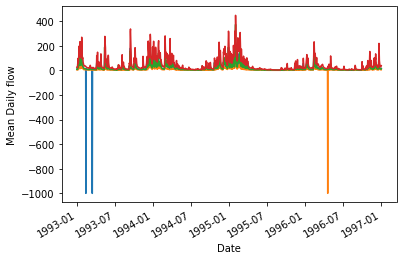

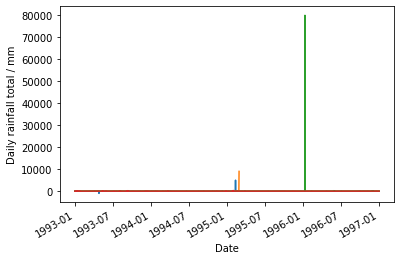

Interpolated Data



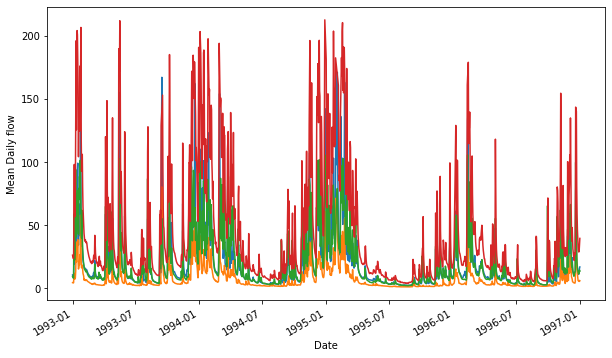

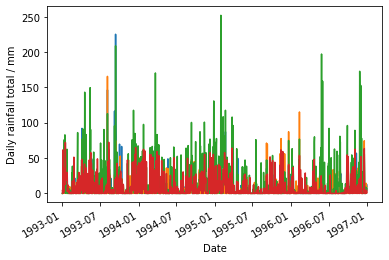

In [101]:
# Plot dataset 
df = pd.read_excel('data.xlsx', header = 0, skiprows=1, usecols="A:I")
new_df = pd.read_excel('data.xlsx', header = 0, skiprows=1, usecols="B:I")
df_dates = pd.read_excel('data.xlsx', header = 0, skiprows=1, usecols="A")

df.columns = ['Dates','Crakehill', 'Skip Bridge', 'Westwick', 'Skelton', 'Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']
df[['Skip Bridge','Skelton','East Cowton']] = df[['Skip Bridge','Skelton','East Cowton']].apply(pd.to_numeric, errors='coerce')

new_df.columns = ['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton', 'Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']
new_df[['Skip Bridge','Skelton','East Cowton']] = new_df[['Skip Bridge','Skelton','East Cowton']].apply(pd.to_numeric, errors='coerce')
# ----------- Raw Data plots (looking for outliers)
print('Raw Data')
print()
# mean daily flow plot
plt.plot(df_dates.to_numpy(), df[['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton']].to_numpy())
plt.xlabel("Date")
plt.ylabel ('Mean Daily flow')
plt.gcf().autofmt_xdate()
plt.show()

# daily rainfall total
plt.plot(df_dates.to_numpy(), df[['Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']].to_numpy())
plt.xlabel("Date")
plt.ylabel ('Daily rainfall total / mm')
plt.gcf().autofmt_xdate()
plt.show()


# ----------- Interpolated Data plots

# Daily Flow outliers : upper and lower bound checked
new_df[['Crakehill','Skip Bridge','Westwick', 'Skelton']] = new_df[['Crakehill','Skip Bridge','Westwick', 'Skelton']].mask(new_df.sub(new_df.mean()).div(new_df.std()).abs().lt(-3))
new_df[['Crakehill','Skip Bridge','Westwick', 'Skelton']] = new_df[['Crakehill','Skip Bridge','Westwick', 'Skelton']].mask(new_df.sub(new_df.mean()).div(new_df.std()).abs().gt(3))

# Daily Rainfall outliers : only upper bound checked
new_df[['Arkengarthdale','East Cowton','Malham Tarn', 'Snaizeholme']] = new_df[['Arkengarthdale','East Cowton','Malham Tarn', 'Snaizeholme']].mask(new_df.sub(new_df.mean()).div(new_df.std()).abs().gt(3))

# interpolation
new_df[new_df < 0] = nan
new_df = new_df.interpolate()

print('Interpolated Data')
print()
# mean daily flow plot
plt.figure(figsize=(10,6))
plt.plot(df_dates.to_numpy(), new_df[['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton']].to_numpy())
plt.xlabel("Date")
plt.ylabel('Mean Daily flow')
plt.gcf().autofmt_xdate()
plt.show()

# daily rainfall total
plt.plot(df_dates.to_numpy(), new_df[['Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']].to_numpy())
plt.xlabel("Date")
plt.ylabel('Daily rainfall total / mm')
plt.gcf().autofmt_xdate()
plt.show()


